G:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
G:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Results saved to 'all_operation_results.csv'
Dataset: Mozilla, Classifier: KNeighborsClassifier, Feature Type: TF-IDF, Accuracy: 0.5530, Balanced Accuracy: 0.5056, Precision: 0.5278, Recall: 0.5530, F1-score: 0.5321
Dataset: Mozilla, Classifier: KNeighborsClassifier, Feature Type: BERT_Scaled, Accuracy: 0.5860, Balanced Accuracy: 0.5481, Precision: 0.5713, Recall: 0.5860, F1-score: 0.5742
Dataset: Mozilla, Classifier: MultinomialNB, Feature Type: TF-IDF, Accuracy: 0.5910, Balanced Accuracy: 0.5084, Precision: 0.5400, Recall: 0.5910, F1-score: 0.5098
Dataset: Mozilla, Classifier: MultinomialNB, Feature Type: BERT_Scaled, Accuracy: 0.6340, Balanced Accuracy: 0.5518, Precision: 0.6425, Recall: 0.6340, F1-score: 0.5578
Dataset: Mozilla, Classifier: MLPClassifier, Feature Type: TF-IDF, Accuracy: 0.5960, Balanced Accuracy: 0.5486, Precision: 0.5758, Recall: 0.5960, F1-score: 0.5750
Dataset: Mozilla, Classifier: MLPClassifier, Feature Type: BERT_Scaled, Accuracy: 0.6210, Balanced Accuracy: 0.

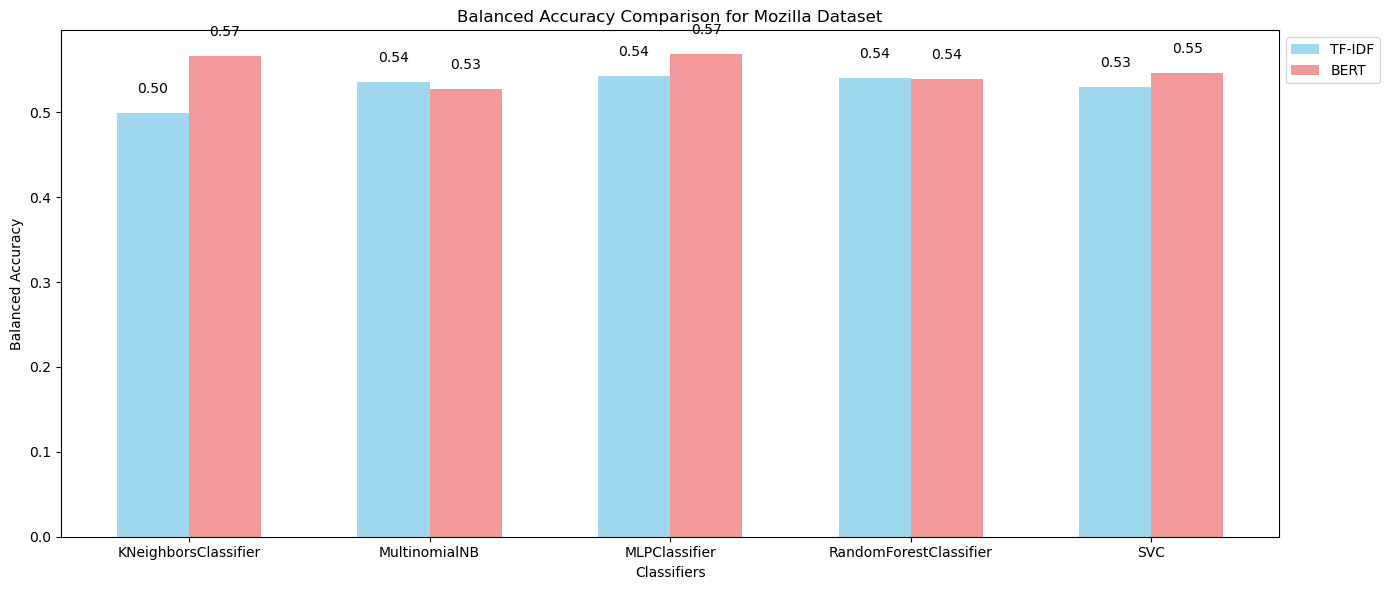

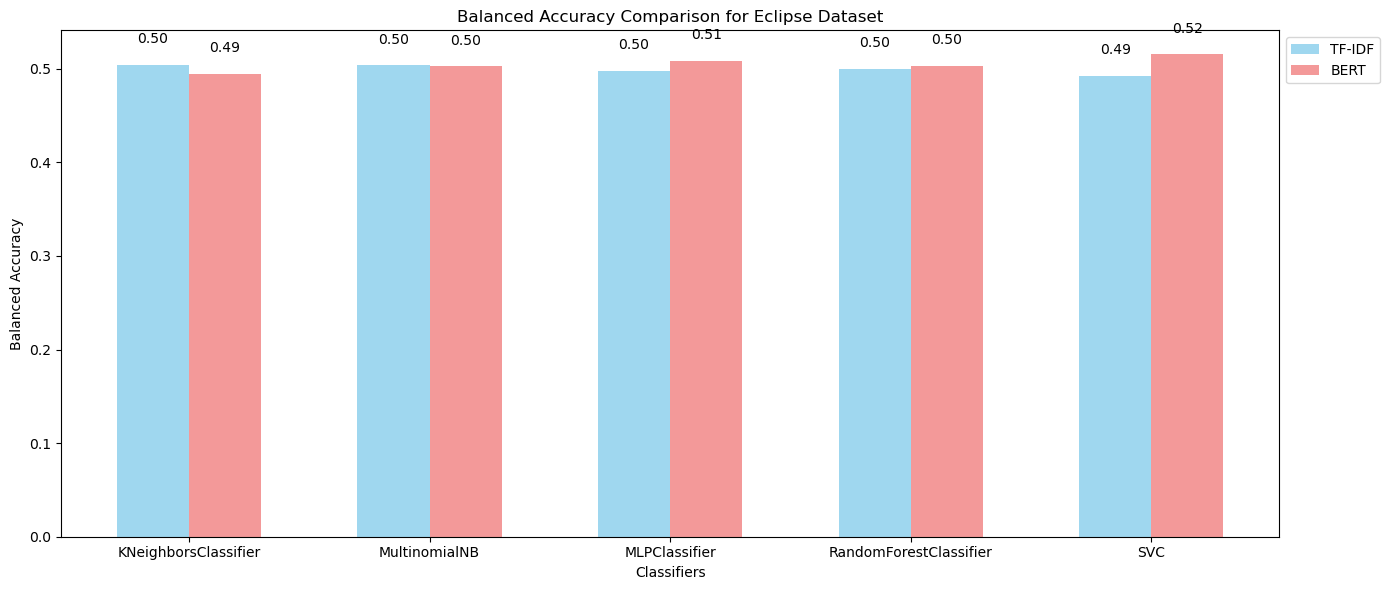

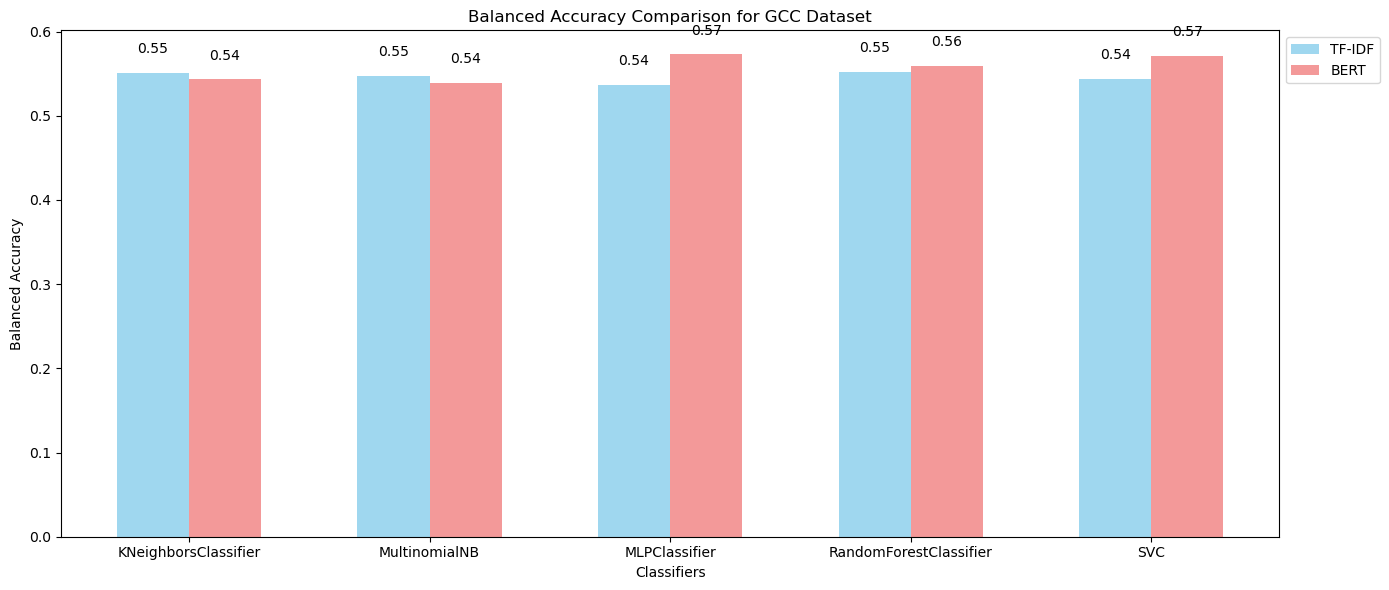

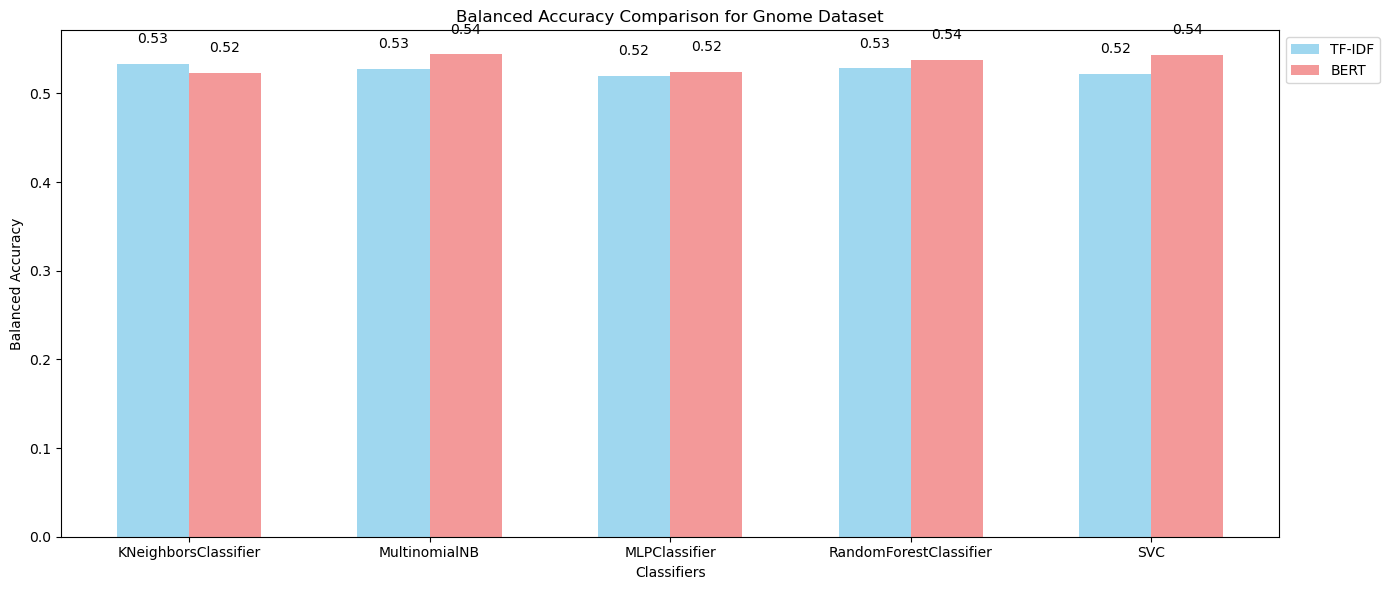

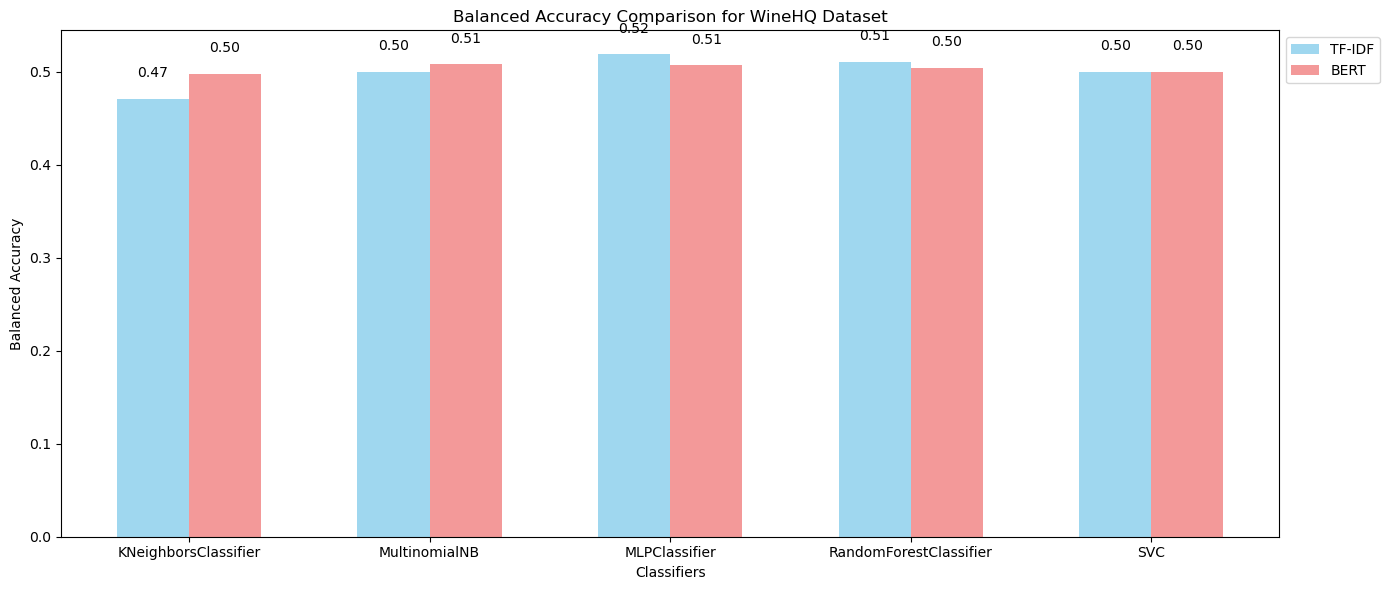

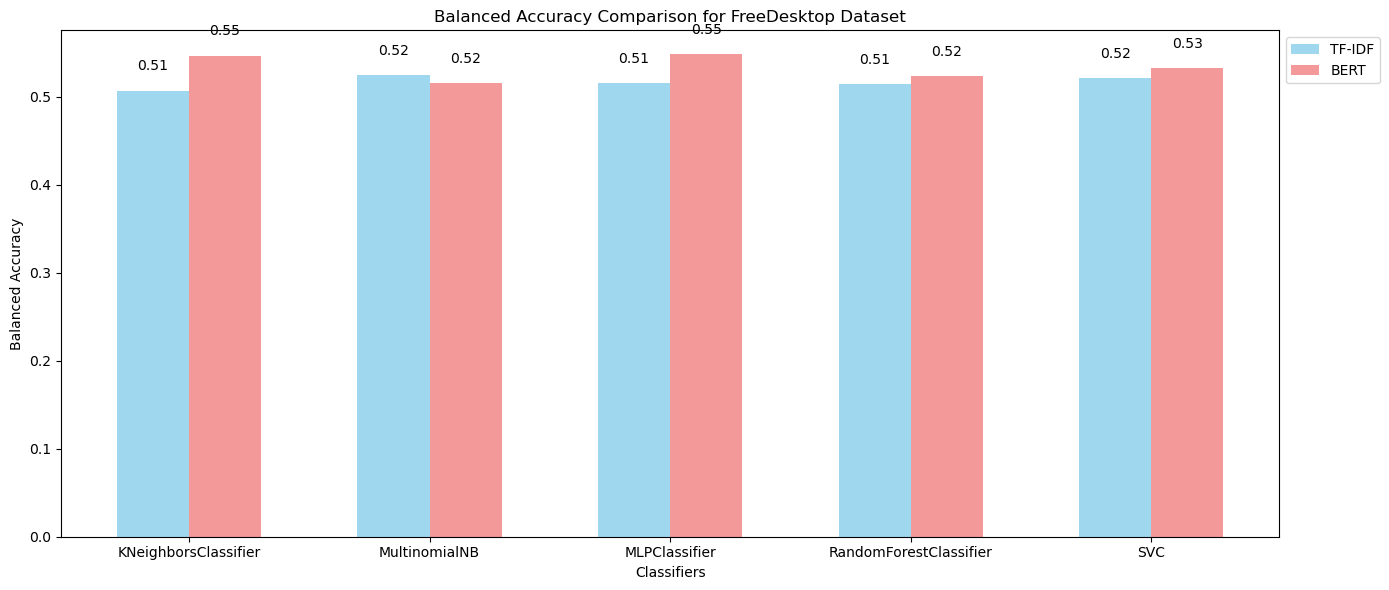

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_and_preprocess_data(data_path):
    bug_reports = pd.read_csv(data_path)

    bug_reports['creation_date'] = pd.to_datetime(bug_reports['creation_date'], errors='coerce')
    bug_reports['resolution_date'] = pd.to_datetime(bug_reports['resolution_date'])
    bug_reports['bug_fix_time'] = (bug_reports['resolution_date'] - bug_reports['creation_date']).dt.days
    bug_reports = bug_reports.dropna(subset=['bug_fix_time', 'short_description'])

    threshold = 10
    bug_reports['bug_class'] = np.where(bug_reports['bug_fix_time'] <= threshold, 'short-lived', 'long-lived')

    return bug_reports

def extract_tfidf_features(bug_reports):
    tfidf_vectorizer = TfidfVectorizer(max_features=128, stop_words='english')
    tfidf_features = tfidf_vectorizer.fit_transform(bug_reports['short_description']).toarray()

    return tfidf_features
def extract_bert_features(bug_reports):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    def extract_bert_feature(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

    bert_features = np.array(bug_reports['short_description'].apply(extract_bert_feature).tolist())
    bert_features = torch.tensor(bert_features)

    return bert_features

def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, classifier, feature_type, dataset_name):
    if isinstance(classifier, MultinomialNB):
        scaler = MinMaxScaler()  # Use MinMaxScaler for NB classifier
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        classifier.fit(X_train_scaled, y_train)
        predictions = classifier.predict(X_test_scaled)
    else:
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    balanced_accuracy = np.mean([cm[i, i] / np.sum(cm[i]) for i in range(len(np.unique(y_test)))])

    acc_score = accuracy_score(y_test, predictions)
    class_report = classification_report(y_test, predictions, output_dict=True)

    # Extract precision, recall, f1-score for each class from classification report
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']

    return {
        'Dataset': dataset_name,
        'Classifier': classifier.__class__.__name__,
        'Feature Type': feature_type,
        'Accuracy': acc_score,
        'Balanced Accuracy': balanced_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }

def plot_bar_chart(accuracies_tfidf, accuracies_bert, classifiers, datasets):
    bar_width = 0.3
    opacity = 0.8

    for idx, dataset in enumerate(datasets):
        plt.figure(figsize=(14, 6))
        index = np.arange(len(classifiers))

        tfidf_vals = [accuracies_tfidf[dataset][classifier] for classifier in classifiers]
        bert_vals = [accuracies_bert[dataset][classifier] for classifier in classifiers]

        plt.bar(index, tfidf_vals, bar_width,
                alpha=opacity,
                color='skyblue',
                label='TF-IDF')

        plt.bar(index + bar_width, bert_vals, bar_width,
                alpha=opacity,
                color='lightcoral',
                label='BERT')

        for i in range(len(classifiers)):
            plt.text(index[i], tfidf_vals[i] + 0.02, f'{tfidf_vals[i]:.2f}', ha='center', va='bottom')
            plt.text(index[i] + bar_width, bert_vals[i] + 0.02, f'{bert_vals[i]:.2f}', ha='center', va='bottom')

        plt.xlabel('Classifiers')
        plt.ylabel('Balanced Accuracy')
        plt.title(f'Balanced Accuracy Comparison for {dataset} Dataset')
        plt.xticks(index + 0.5 * bar_width, classifiers)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()

        # Save the plot as an image
        plt.savefig(f'{dataset}_balanced_accuracy_comparison.png')

        plt.show()

def create_summary_table(results):
    # Initialize an empty list to collect data
    summary_data = []

    # Iterate over results and append to summary_data list
    for result in results:
        summary_data.append(result)

    # Create DataFrame from summary_data list
    df = pd.DataFrame(summary_data)

    return df

def display_all_values_table(results):
    for result in results:
        print(f"Dataset: {result['Dataset']}, Classifier: {result['Classifier']}, Feature Type: {result['Feature Type']}, "
              f"Accuracy: {result['Accuracy']:.4f}, Balanced Accuracy: {result['Balanced Accuracy']:.4f}, "
              f"Precision: {result['Precision']:.4f}, Recall: {result['Recall']:.4f}, F1-score: {result['F1-score']:.4f}")

# Load and preprocess data for different projects
data_paths = [
    r'C:\Users\Admin\Desktop\New folder\mozilla_bug_report_data.csv',
    r'C:\Users\Admin\Desktop\New folder\eclipse_bug_report_data.csv',
    r'C:\Users\Admin\Desktop\New folder\gcc_bug_report_data.csv',
    r'C:\Users\Admin\Desktop\New folder\gnome_bug_report_data.csv',
    r'C:\Users\Admin\Desktop\New folder\winehq_bug_report_data.csv',
    r'C:\Users\Admin\Desktop\New folder\freedesktop_bug_report_data.csv'
]

# Define classifiers to be evaluated
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    MultinomialNB(),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='linear')
]

# Initialize lists to store results
all_results = []

# Initialize dictionaries to store balanced accuracy for each dataset and classifier
accuracies_tfidf = {'Mozilla': {}, 'Eclipse': {}, 'GCC': {}, 'Gnome': {}, 'WineHQ': {}, 'FreeDesktop': {}}
accuracies_bert = {'Mozilla': {}, 'Eclipse': {}, 'GCC': {}, 'Gnome': {}, 'WineHQ': {}, 'FreeDesktop': {}}

for data_path in data_paths:
    # Load and preprocess data
    bug_reports = load_and_preprocess_data(data_path)
    
    # Define the dataset name based on the file path
    dataset_name = 'Mozilla' if 'mozilla' in data_path else 'Eclipse' if 'eclipse' in data_path else 'GCC' if 'gcc' in data_path else 'Gnome' if 'gnome' in data_path else 'WineHQ' if 'winehq' in data_path else 'FreeDesktop'

    # Extract features using different methods
    tfidf_features = extract_tfidf_features(bug_reports)
    bert_features = extract_bert_features(bug_reports)

    # Define target variable
    y = bug_reports['bug_class']

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(tfidf_features, y):
        X_train_tfidf, X_test_tfidf = tfidf_features[train_index], tfidf_features[test_index]
        X_train_bert, X_test_bert = bert_features[train_index], bert_features[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Apply Min-Max scaling to the input data for MultinomialNB classifier
        scaler = MinMaxScaler()
        X_train_bert_scaled = scaler.fit_transform(X_train_bert)
        X_test_bert_scaled = scaler.transform(X_test_bert)
        
        # Train and evaluate classifiers with different feature types
        for classifier in classifiers:
            result_tfidf = train_and_evaluate_classifier(X_train_tfidf, X_test_tfidf, y_train, y_test, classifier, 'TF-IDF', dataset_name)
            result_bert = train_and_evaluate_classifier(X_train_bert_scaled, X_test_bert_scaled, y_train, y_test, classifier, 'BERT_Scaled', dataset_name)
            
            all_results.extend([result_tfidf, result_bert])
            
            # Store balanced accuracies for plotting
            accuracies_tfidf[dataset_name][classifier.__class__.__name__] = result_tfidf['Balanced Accuracy']
            accuracies_bert[dataset_name][classifier.__class__.__name__] = result_bert['Balanced Accuracy']

# Create a summary table
summary_df = create_summary_table(all_results)

# Save the results to a CSV file
summary_df.to_csv('all_operation_results.csv', index=False)
print(f"Results saved to 'all_operation_results.csv'")

# Display all values in the table
display_all_values_table(all_results)

# Plot bar charts for each dataset
classifiers_names = [clf.__class__.__name__ for clf in classifiers]
plot_bar_chart(accuracies_tfidf, accuracies_bert, classifiers_names, ['Mozilla', 'Eclipse', 'GCC', 'Gnome', 'WineHQ', 'FreeDesktop'])
